In [136]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
%autoreload 2

import os
import io
import sys
import ast
sys.path.append(os.path.join(os.getcwd(), '..','..'))
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mlpremier.cnn.preprocess import generate_cnn_data, split_preprocess_cnn_data, preprocess_cnn_data
from mlpremier.cnn.model import build_train_cnn, full_cnn_pipeline
from mlpremier.cnn.evaluate import gridsearch_analysis
import tensorflow as tf
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from config import STANDARD_CAT_FEATURES, STANDARD_NUM_FEATURES, NUM_FEATURES_DICT


# Run Full Training

======= Generating CNN Data for Season: ['2020-21', '2021-22'], Position: FWD =======
Total players of type FWD = 190.
0 players dropped due to low average playtime.
Generated windowed dataframe for CNN of shape: (5385, 6).
Generated combined features dataframe for preprocessing of shape: (6511, 6).

========== EDA ==========
Selected Statistics:
      total_points  clean_sheets  goals_conceded         bps  \
mean      1.352634      0.081554        0.426509    4.387652   
min      -2.000000      0.000000        0.000000  -16.000000   
max      24.000000      1.000000        9.000000  128.000000   
std       2.628695      0.273705        0.917870   10.558473   

      matchup_difficulty  
mean           -0.254032  
min            -3.000000  
max             3.000000  
std             1.338766  


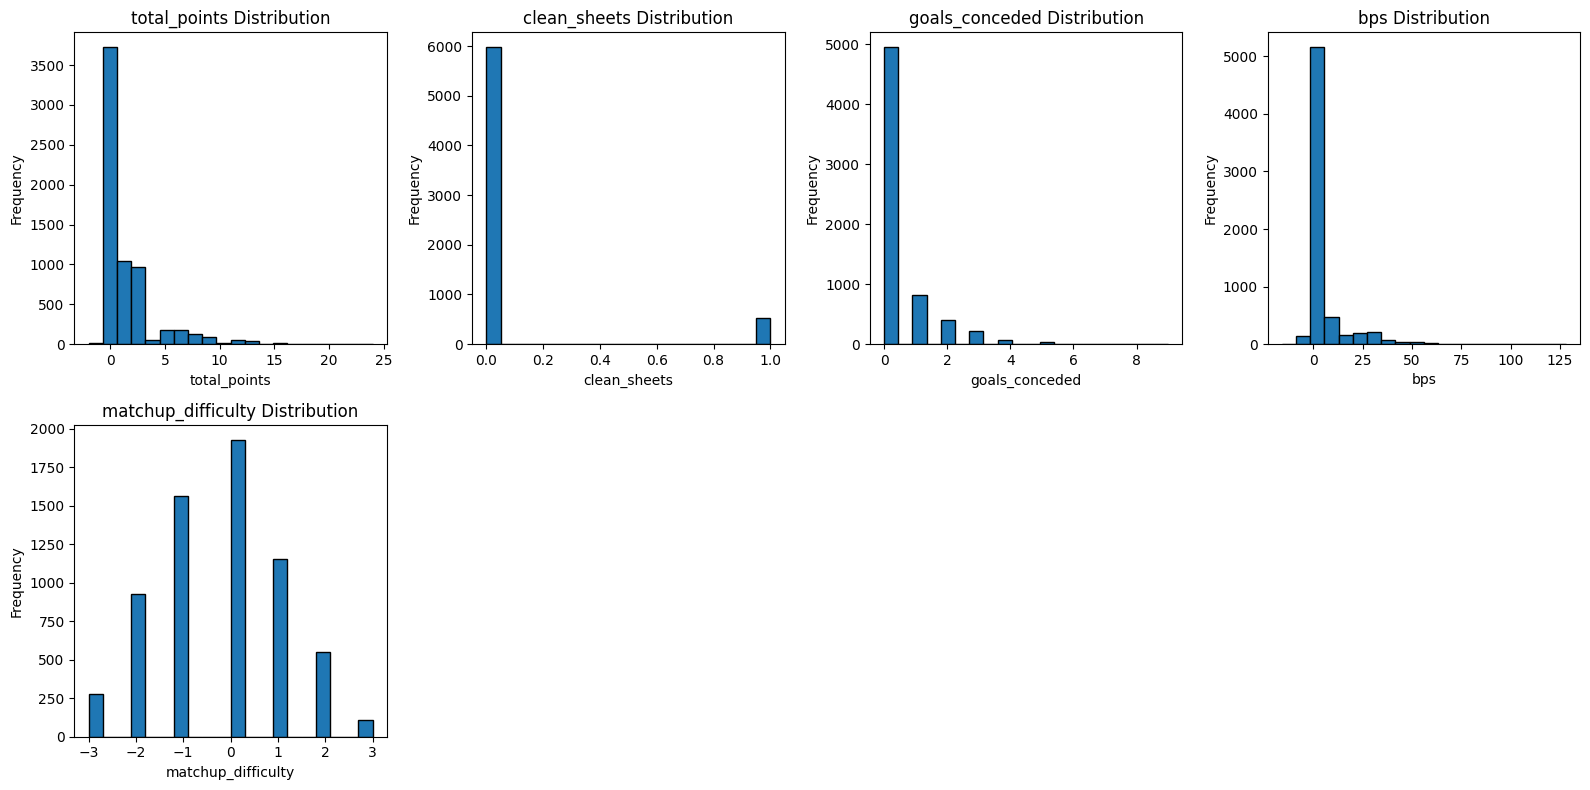

========== Done Generating CNN Data ==========

========== Splitting CNN Data ==========

Shape of windowed_df: (5385, 6)
Shape of a given window (prior to preprocessing): (6, 6)
Skill Distribution of Players:



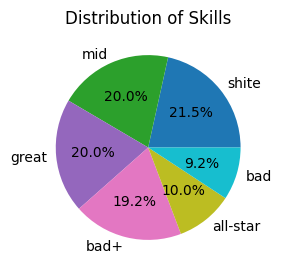

========== Preprocessing CNN Data ==========

Mean of Standard Scaler:
[ 1.32016238  0.07794317  0.44817321  4.25899865 -0.25575101]

Standard Deviation of Standard Scaler:
[ 2.63083865  0.26808213  0.95015491 10.50189928  1.33439107]
Transforming features using StandardScaler + OHE Pipeline.
========== Done Preprocessing CNN Data ==========

========== Done Splitting CNN Data ==========

====== Building CNN Architecture ======
====== Done Building CNN Architecture ======
Epoch 69: early stopping


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.741696357727051, Test Mean Absolute Error (MAE): 1.330739140510559


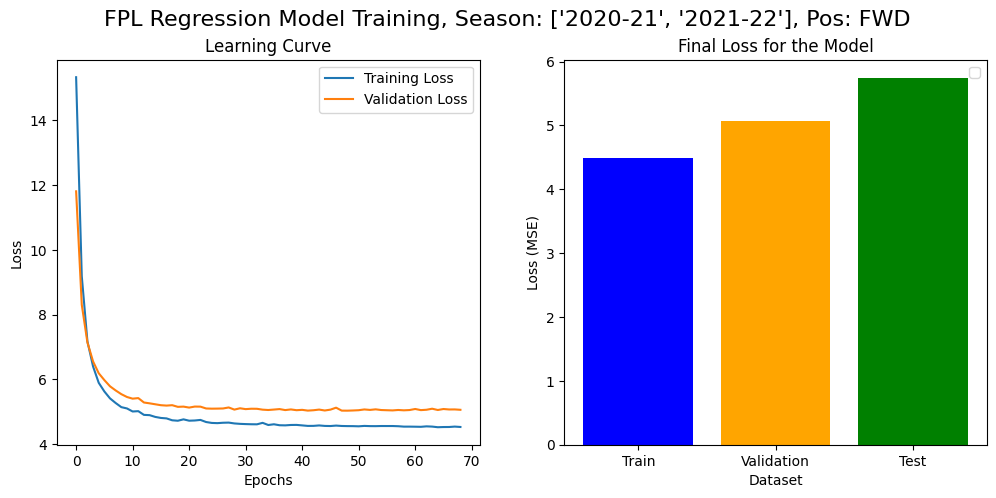

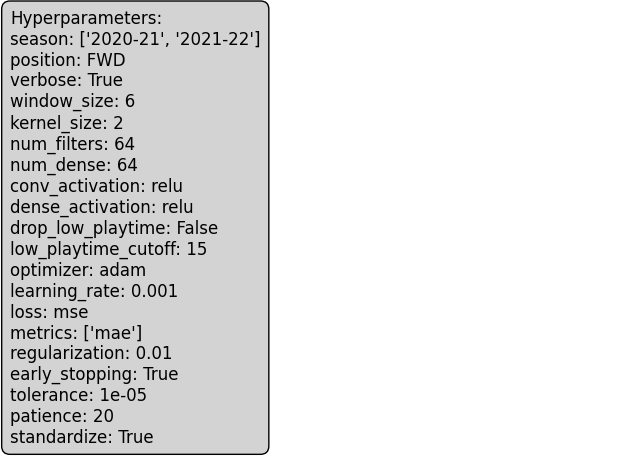

(<keras.src.engine.functional.Functional at 0x2db827c70>,
 {'season': ['2020-21', '2021-22'],
  'position': 'FWD',
  'train_mse': 4.496730327606201,
  'train_mae': 1.117430567741394,
  'val_mse': 5.063578128814697,
  'val_mae': 1.2492954730987549,
  'test_mse': 5.741696357727051,
  'test_mae': 1.330739140510559,
  'verbose': True,
  'window_size': 6,
  'kernel_size': 2,
  'num_filters': 64,
  'num_dense': 64,
  'conv_activation': 'relu',
  'dense_activation': 'relu',
  'drop_low_playtime': False,
  'low_playtime_cutoff': 15,
  'optimizer': 'adam',
  'learning_rate': 0.001,
  'loss': 'mse',
  'metrics': ['mae'],
  'regularization': 0.01,
  'early_stopping': True,
  'tolerance': 1e-05,
  'patience': 20,
  'standardize': True})

In [138]:
SEED = 229

random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'clean_data')

full_cnn_pipeline(DATA_DIR,
                season = ['2020-21', '2021-22'], 
                position = 'FWD', 
                window_size=6,
                kernel_size=2,
                num_filters=64,
                num_dense=64,
                batch_size = 32,
                epochs = 1000,  
                drop_low_playtime = False,
                low_playtime_cutoff = 15,
                num_features = ['total_points', 'clean_sheets', 'goals_conceded', 'bps', 'matchup_difficulty'],
                cat_features = STANDARD_CAT_FEATURES, 
                conv_activation = 'relu',
                dense_activation = 'relu',
                optimizer='adam',
                learning_rate= 0.001,  
                loss = 'mse',
                metrics = ['mae'],
                verbose = True,
                regularization = 0.01, 
                early_stopping = True, 
                tolerance = 1e-5, # only used if early stopping is turned on, threshold to define low val loss decrease
                patience = 20,   # num of iterations before early stopping bc of low val loss decrease
                plot = True, 
                draw_model = False,
                standardize= True,)

# GridSearch for Best Model

In [139]:
from mlpremier.cnn.experiment import gridsearch_cnn

#gridsearch_cnn(epochs=100, verbose=False)

#PERFORMING VIA COMMAND LINE SCRIPT NOW FOR EFFICIENCY

## Investigate GridSearch Results

## V9 Best: Learning Curve, Filter Investigation

In [280]:
def investigate_model(expt_name: str = 'gridsearch', 
                      drop_low_playtime: bool = True):
    """
    Investigate the best model for the given experiment and drop status.

    Retrains the model on the same exact data split (to avoid data leakage), and
    generates learning curves.
    """
    season =  "['2020-21', '2021-22']"
    best_params = gridsearch_analysis(expt_name, 
                        season=season, 
                        eval_top=1,
                        drop_low_playtime=drop_low_playtime)
    
    POSITIONS = ['GK', 'DEF', 'MID', 'FWD']
    best_models = {}
    for position in POSITIONS: 

        serialized_dataset = best_params.loc[position,'dataset']
        loaded_dataset = pickle.loads(ast.literal_eval(serialized_dataset))
        print(loaded_dataset.keys())

        # Retrieve individual datasets
        X_train = loaded_dataset['X_train']
        d_train = loaded_dataset['d_train']
        y_train = loaded_dataset['y_train']
        X_val = loaded_dataset['X_val']
        d_val = loaded_dataset['d_val']
        y_val = loaded_dataset['y_val']
        X_test = loaded_dataset['X_test']
        d_test = loaded_dataset['d_test']
        y_test = loaded_dataset['y_test']

    
        print(f"\n======= Retraining and Filter Analysis for {position} model: =======\n")
        # Clean up and consolidate parameters in the 'params' dictionary
        params = best_params.loc[position, :].to_dict()
        params['season'] = ['2020-21', '2021-22']
        params['metrics'] = ['mae']
        params['num_features'] = NUM_FEATURES_DICT[params['position']][params['amt_num_features']]
        params.pop('amt_num_features')
        params.pop('dataset')

        # Add the datasets to params
        params.update({
            'X_train': X_train,
            'd_train': d_train,
            'y_train': y_train,
            'X_val': X_val,
            'd_val': d_val,
            'y_val': y_val,
            'X_test': X_test,
            'd_test': d_test,
            'y_test': y_test,
            'plot': True,
        })

        # =========== Qualitative Analysis of Best & Worst Ex =============

        model, expt_res = build_train_cnn(**params)
        best_models[position] = model

        y_pred = model.predict([X_test, d_test])
        y_test_flattened = y_test.flatten()
        y_pred_flattened = y_pred.flatten()
        mse_per_example = np.square(y_test_flattened - y_pred_flattened)

        results_df = pd.DataFrame({'Actual Score': y_test_flattened, 'Predicted Score': y_pred_flattened, 'MSE': mse_per_example})

        # Add X_test features to the DataFrame
        for i in range(X_test.shape[1]):  # Assuming X_test has shape (n_examples, h, w)
            results_df[f'stdized_pts_week{i}'] = X_test[:, i, :].flatten()  
            # !!!! THESE COLUMN NAMES ONLY MAKE SENSE WHEN (AND USUALLY THEY DO)
            # !!!! THE BEST MODEL USES PTSONLY AS THE NUM_FEATURES

        results_df['d_test'] = d_test

        results_df.sort_values(by='MSE', ascending=False, inplace=True)

        print(f"\nWorst two examples for {position}:\n")
        display(results_df.head(2))

        print(f"\nBest two examples for {position}:\n")
        display(results_df.tail(2))


        for layer in model.layers:
            if 'conv' not in layer.name:
                continue
            filters, biases = layer.get_weights()

        # retrieve filter weights from the second hidden layer
        filters, biases = model.layers[1].get_weights()

        # normalize filter values by z-score normalization
        mean_value, std_dev = filters.mean(), filters.std()
        normalized_filters = (filters - mean_value) / std_dev
        mean_filter = normalized_filters.mean(axis=-1)

        # set greyscale color map
        cmap = plt.cm.Greys_r
        cmap.set_bad('0.5')  # Set the color for NaN values (if any) to medium-grey

        # plot the normalized average filter with numeric values inside pixels
        fig, ax = plt.subplots()
        img = ax.imshow(mean_filter, cmap=cmap, vmin=-1, vmax=1)

        # add text annotations with normalized values inside each pixel
        for i, value in enumerate(mean_filter):
            value = value[0]
            # set text color based on brightness
            text_color = 'white' if value < 0 else 'black'
            ax.text(0, i, f"{value:.4f}", ha='center', va='center', fontsize=8, color=text_color)
        ax.set_title("Averaged 1D Convolution Filter (Normalized)")
        ax.axis('off')
        plt.show()

    return best_models


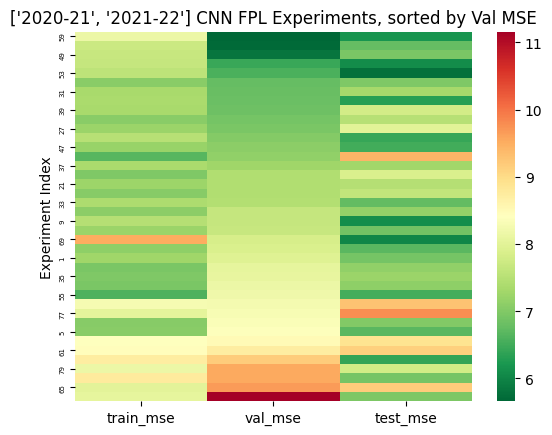


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,...,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features,dataset
GK,"['2020-21', '2021-22']",GK,9,2,64,64,relu,relu,True,15,...,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly,"b""\x80\x04\x95\x88\x03\x01\x00\x00\x00\x00\x00..."
DEF,"['2020-21', '2021-22']",DEF,6,4,64,64,relu,relu,True,15,...,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly,b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...
MID,"['2020-21', '2021-22']",MID,9,4,64,64,relu,relu,True,15,...,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly,b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,True,15,...,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly,"b""\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00..."



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,6.662291,7.142148,9.426111
DEF,7.344709,6.792804,7.322718
MID,8.152804,5.662549,6.187357
FWD,9.518203,7.853109,6.021454



Average Val Performance:
6.862652540206909

Average Test Performance:
7.239409923553467
dict_keys(['X_train', 'd_train', 'y_train', 'X_val', 'd_val', 'y_val', 'X_test', 'd_test', 'y_test'])

======= Retraining and Filter Analysis for GK model: =======

Epoch 145: early stopping


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 9.231099128723145, Test Mean Absolute Error (MAE): 2.3035480976104736


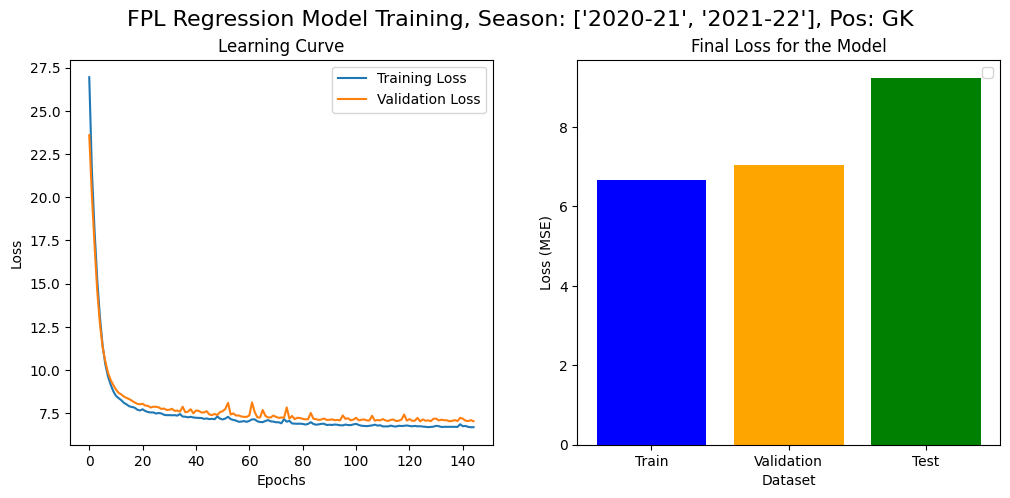

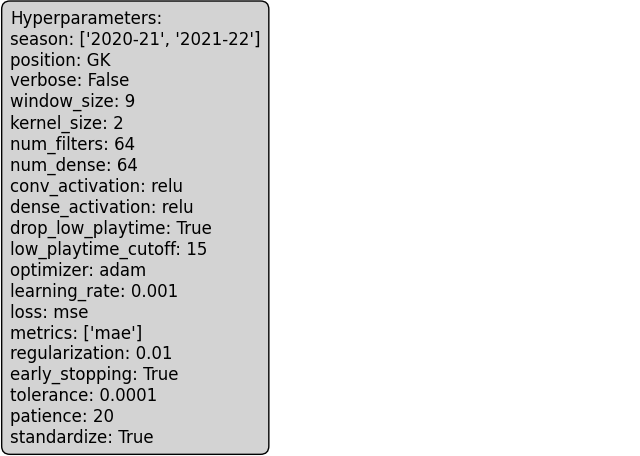

9/9 [==============================] - 0s 542us/step

Worst two examples for GK:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,stdized_pts_week6,stdized_pts_week7,stdized_pts_week8,d_test
233,11,2.115802,78.928973,-0.870053,-0.870053,-0.870053,0.19255,0.192550,-0.161651,-0.515852,-0.515852,-0.161651,-2.0
41,12,3.541153,71.552089,2.671956,0.192550,0.192550,0.19255,1.255153,-0.515852,2.671956,0.546751,2.317755,0.0



Best two examples for GK:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,stdized_pts_week6,stdized_pts_week7,stdized_pts_week8,d_test
14,2,1.983401,0.000276,-0.161651,1.255153,-0.161651,2.671956,0.192550,-0.161651,-0.161651,-0.870053,-0.870053,-1.0
57,3,2.990021,0.000100,0.546751,0.546751,-0.515852,-0.161651,-0.161651,-0.161651,2.671956,-0.161651,0.192550,-1.0


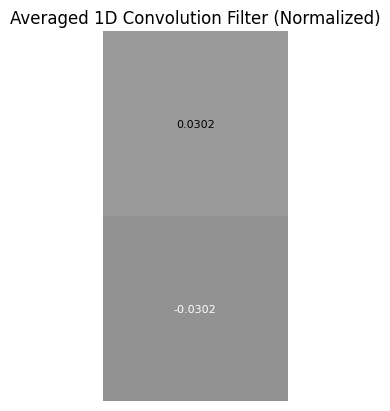

dict_keys(['X_train', 'd_train', 'y_train', 'X_val', 'd_val', 'y_val', 'X_test', 'd_test', 'y_test'])

======= Retraining and Filter Analysis for DEF model: =======

Epoch 170: early stopping


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 7.442805767059326, Test Mean Absolute Error (MAE): 2.032618761062622


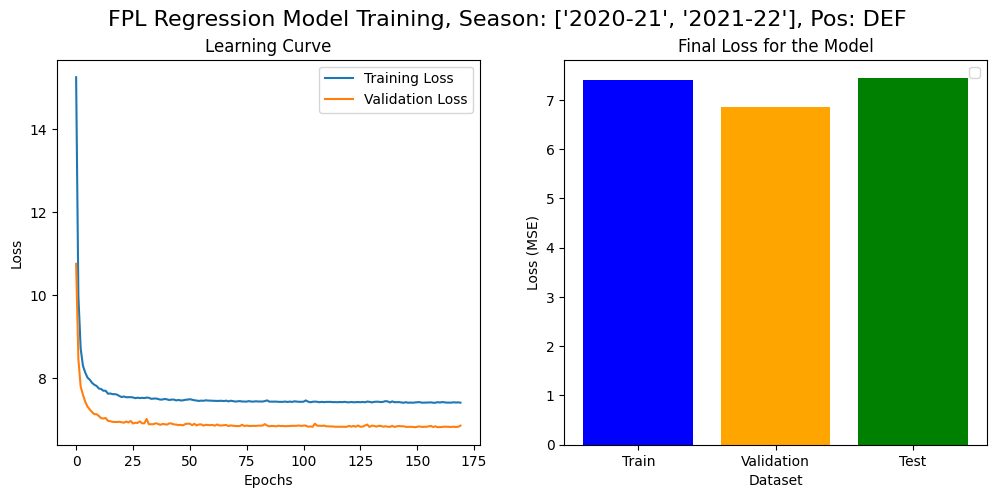

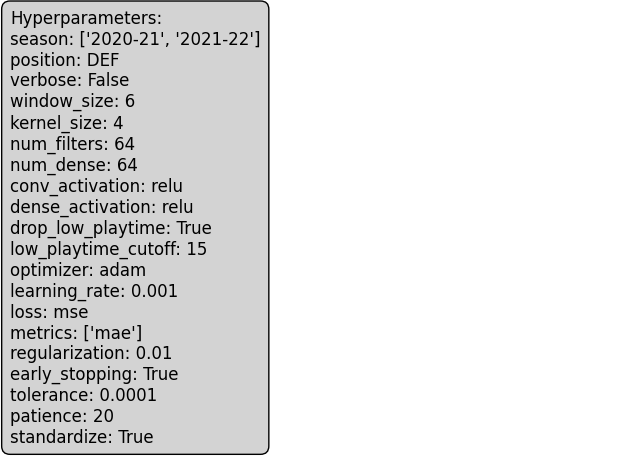

42/42 [==============================] - 0s 396us/step

Worst two examples for DEF:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,d_test
302,14,1.140955,165.355036,-0.669133,-0.669133,-0.669133,-0.669133,-0.669133,-0.669133,2.0
399,17,4.370134,159.513506,1.388594,1.388594,1.388594,0.016776,-0.326179,2.074502,2.0



Best two examples for DEF:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,d_test
105,2,2.004092,0.000017,0.016776,1.388594,1.388594,0.016776,-0.326179,2.074502,-2.0
235,1,1.003415,0.000012,-0.326179,-0.326179,-0.326179,0.016776,-0.669133,-0.669133,-1.0


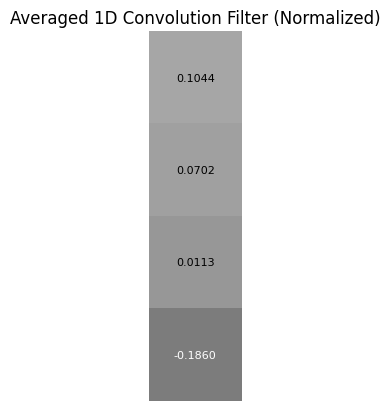

dict_keys(['X_train', 'd_train', 'y_train', 'X_val', 'd_val', 'y_val', 'X_test', 'd_test', 'y_test'])

======= Retraining and Filter Analysis for MID model: =======

Epoch 57: early stopping


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.9961395263671875, Test Mean Absolute Error (MAE): 1.5820969343185425


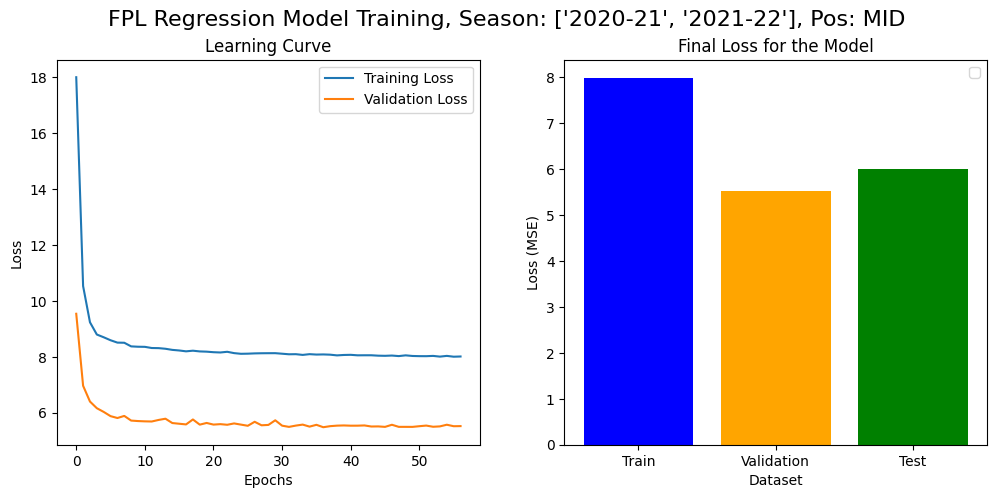

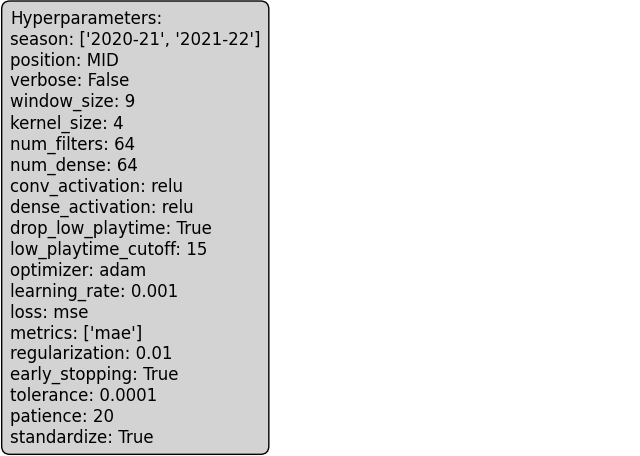

50/50 [==============================] - 0s 389us/step

Worst two examples for MID:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,stdized_pts_week6,stdized_pts_week7,stdized_pts_week8,d_test
1481,19,4.865767,199.776542,-0.430285,0.226883,2.526969,5.155639,0.226883,2.198385,-0.430285,0.226883,0.884050,1.0
1475,18,4.623312,178.935769,1.869802,-0.101701,-0.758869,1.541218,-0.758869,-0.758869,-0.430285,0.226883,2.526969,3.0



Best two examples for MID:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,stdized_pts_week6,stdized_pts_week7,stdized_pts_week8,d_test
991,2,2.005535,0.000031,-0.101701,-0.758869,-0.758869,0.226883,-0.101701,-0.101701,-0.758869,-0.101701,-0.101701,-1.0
539,1,1.002632,0.000007,-0.758869,-0.430285,-0.430285,-0.101701,-1.087453,-0.758869,-0.758869,-0.758869,-0.430285,-1.0


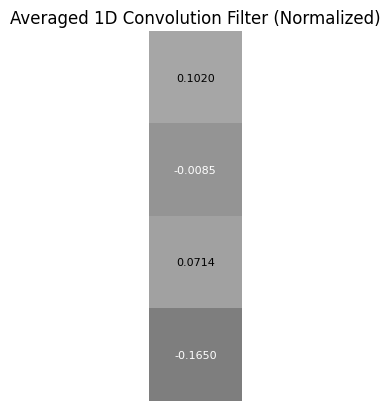

dict_keys(['X_train', 'd_train', 'y_train', 'X_val', 'd_val', 'y_val', 'X_test', 'd_test', 'y_test'])

======= Retraining and Filter Analysis for FWD model: =======

Epoch 128: early stopping


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 6.000322341918945, Test Mean Absolute Error (MAE): 1.7208192348480225


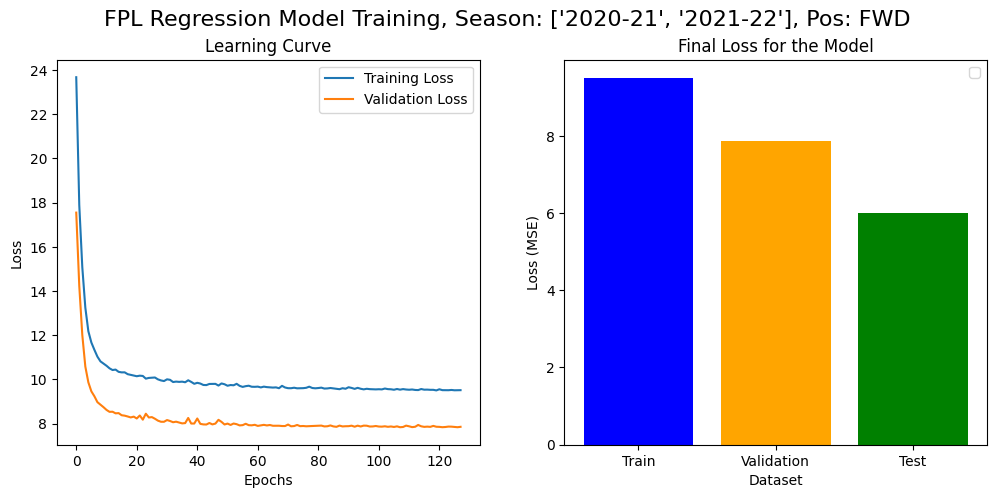

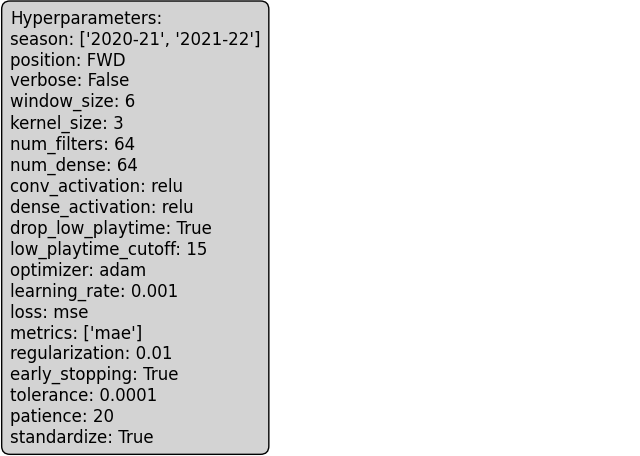

13/13 [==============================] - 0s 597us/step

Worst two examples for FWD:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,d_test
135,13,2.074693,119.362339,1.558458,1.847559,-0.176145,-0.465245,-0.465245,-0.465245,0.0
6,12,2.947647,81.945089,-0.754346,-0.754346,-0.465245,-0.465245,-0.465245,-0.176145,1.0



Best two examples for FWD:



,Actual Score,Predicted Score,MSE,stdized_pts_week0,stdized_pts_week1,stdized_pts_week2,stdized_pts_week3,stdized_pts_week4,stdized_pts_week5,d_test
12,4,3.980247,0.000390,2.714860,-0.176145,-0.465245,1.558458,-0.176145,-0.176145,1.0
162,2,1.997845,0.000005,-0.465245,-0.465245,-0.176145,0.691157,-0.176145,-0.465245,-2.0


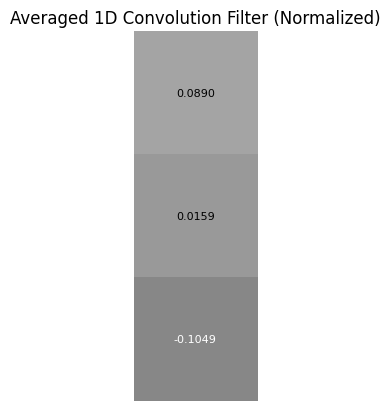

In [281]:
best_models = investigate_model('gridsearch_v9', drop_low_playtime=True)

In [282]:
best_models['MID'].summary()

Model: "model_98"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_197 (InputLayer)      [(None, 9, 1)]               0         []                            
                                                                                                  
 conv1d_98 (Conv1D)          (None, 6, 64)                320       ['input_197[0][0]']           
                                                                                                  
 flatten_98 (Flatten)        (None, 384)                  0         ['conv1d_98[0][0]']           
                                                                                                  
 input_198 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                           

## Run Model on Latest Weeks

In [ ]:
generate_cnn_data('clean_data', season = "2021-22")

## V8

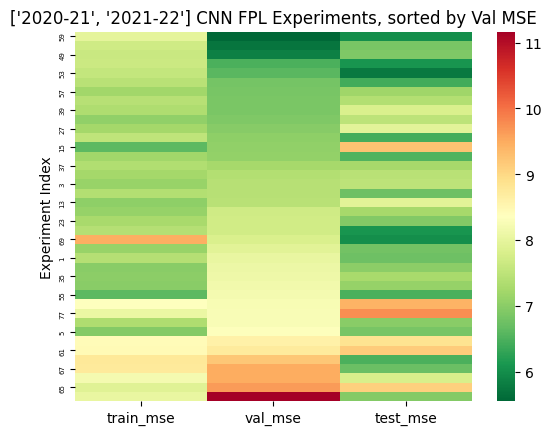


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,9,2,64,64,relu,relu,True,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,6,4,64,64,relu,relu,True,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,9,4,64,64,relu,relu,True,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,True,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,6.626597,7.062074,9.259813
DEF,7.420223,6.847605,7.392525
MID,7.966120,5.552106,6.002896
FWD,9.465921,7.826174,6.006136



Average Val Performance:
6.8219897747039795

Average Test Performance:
7.165342688560486


In [141]:
# with player dropping
best_params = gridsearch_analysis('gridsearch_v8', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = True)

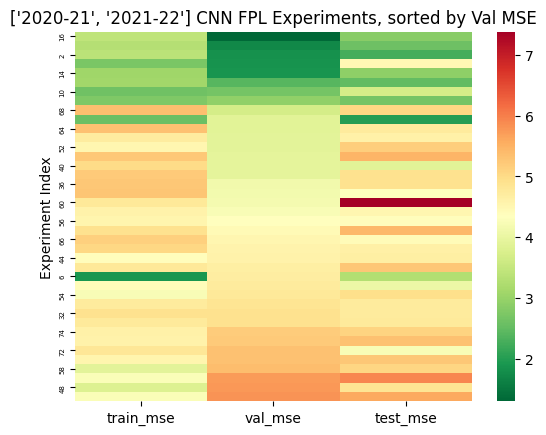


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,9,3,64,64,relu,relu,False,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,6,2,64,64,relu,relu,False,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,6,2,64,64,relu,relu,False,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,False,15,adam,0.001,mse,['mae'],0.01,True,0.0001,20,True,ptsonly



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,3.435112,1.303213,2.849222
DEF,5.198655,3.936277,4.891015
MID,4.715411,3.896753,4.615019
FWD,5.340059,3.686617,5.037661



Average Val Performance:
3.205714911222458

Average Test Performance:
4.3482290506362915


In [142]:
# with player dropping
best_hyperparams = gridsearch_analysis('gridsearch_v8', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = False)

## V7


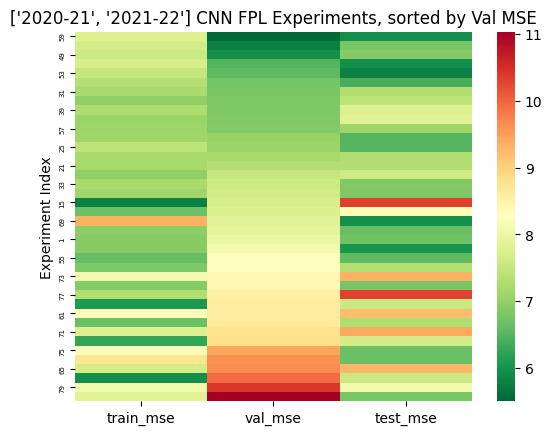


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,3,2,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,6,4,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,9,4,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,6.965347,7.507768,7.612298
DEF,7.218315,6.797379,7.304734
MID,7.793943,5.503473,5.951376
FWD,9.333324,7.843918,5.936503



Average Val Performance:
6.913134336471558

Average Test Performance:
6.701227784156799


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,3,2,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,6,4,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,9,4,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly


In [143]:
# with player dropping
gridsearch_analysis('gridsearch_v7', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = True)

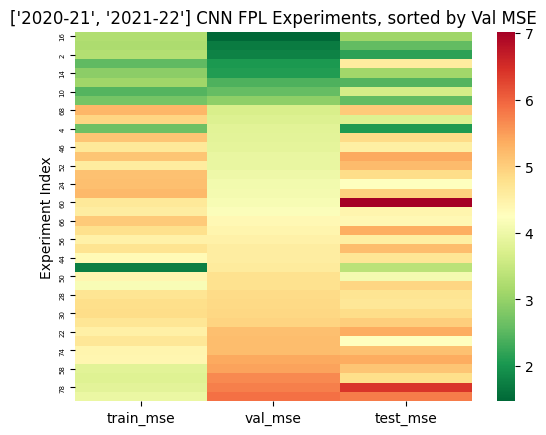


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,9,3,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,6,2,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,3,1,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,3.264033,1.472767,3.087075
DEF,5.114088,3.853492,4.844957
MID,4.917191,3.763637,3.768542
FWD,5.261523,3.700449,5.041334



Average Val Performance:
3.1975861489772797

Average Test Performance:
4.185477018356323


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,9,3,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,6,2,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,3,1,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,False,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly


In [144]:
# without player dropping
gridsearch_analysis('gridsearch_v7', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = False)

## V6  With Player Dropping

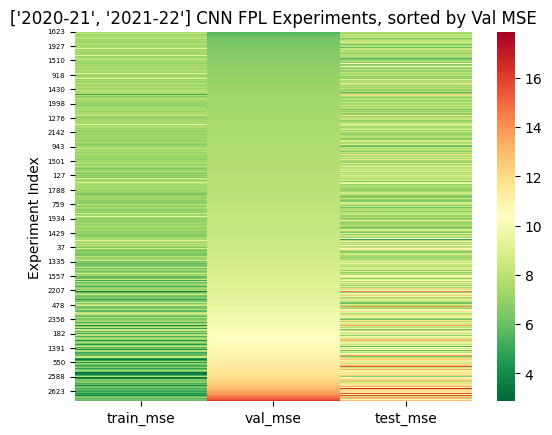


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 5 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,3.0,1.0,64,64.0,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,3,1,64,64.0,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,large
MID,"['2020-21', '2021-22']",MID,3.0,2.0,128.0,64,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,medium
FWD,"['2020-21', '2021-22']",FWD,3.0,1.0,128,128,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,medium



['2020-21', '2021-22'] Mean Performance of Top 5 Model by Position


,train_mse,val_mse,test_mse
GK,7.763064,5.973737,7.543674
DEF,7.880770,6.345948,7.368134
MID,7.726225,5.334068,7.786359
FWD,9.595366,6.183167,8.353703



Average Val Performance:
5.959229826927186

Average Test Performance:
7.762967610359192


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,3.0,1.0,64,64.0,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,3,1,64,64.0,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,large
MID,"['2020-21', '2021-22']",MID,3.0,2.0,128.0,64,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,medium
FWD,"['2020-21', '2021-22']",FWD,3.0,1.0,128,128,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True,medium


In [145]:
gridsearch_analysis('gridsearch_v6', 
                    season="['2020-21', '2021-22']", 
                    eval_top=5,
                    drop_low_playtime = True)

## V6 Best Models Without Player Dropping

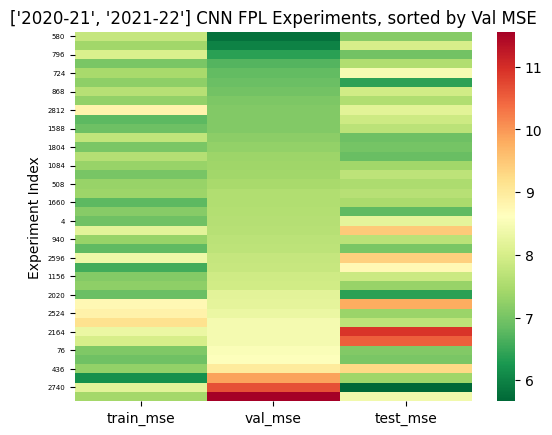


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,9,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,3,2,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,3,2,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,9,4,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,7.799668,5.780939,7.159147
DEF,8.038533,6.400522,6.971214
MID,7.413644,5.994377,8.014818
FWD,8.829316,7.094800,8.160402



Average Val Performance:
6.317659378051758

Average Test Performance:
7.576395392417908


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize,amt_num_features
GK,"['2020-21', '2021-22']",GK,9,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
DEF,"['2020-21', '2021-22']",DEF,3,2,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
MID,"['2020-21', '2021-22']",MID,3,2,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly
FWD,"['2020-21', '2021-22']",FWD,9,4,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True,ptsonly


In [146]:
gridsearch_analysis('gridsearch_v6', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    num_dense=64,
                    num_filters=64,
                    amt_num_features = 'ptsonly',
                    drop_low_playtime = True)

## Other Models

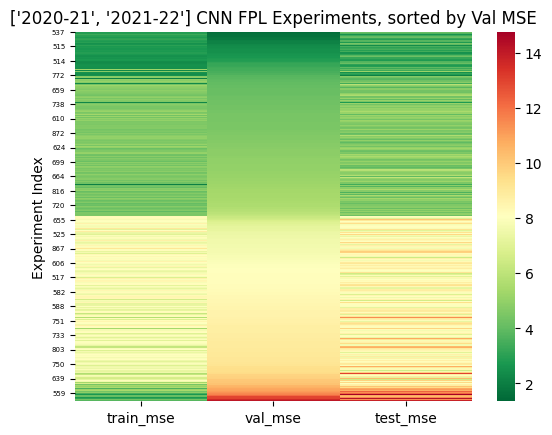


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,"['2020-21', '2021-22']",GK,6,2,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True
DEF,"['2020-21', '2021-22']",DEF,6,1,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True
MID,"['2020-21', '2021-22']",MID,9,3,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True
FWD,"['2020-21', '2021-22']",FWD,6,2,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,3.017067,1.354558,3.231826
DEF,5.195624,4.065986,4.967775
MID,5.203198,3.418591,4.020970
FWD,5.022539,3.957532,4.335554



Average Val Performance:
3.1991667449474335

Average Test Performance:
4.139031410217285


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,"['2020-21', '2021-22']",GK,6,2,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True
DEF,"['2020-21', '2021-22']",DEF,6,1,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True
MID,"['2020-21', '2021-22']",MID,9,3,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True
FWD,"['2020-21', '2021-22']",FWD,6,2,64,64,relu,relu,True,0,adam,0.01,mse,['mae'],0.001,True,0.00001,20,True


In [147]:
gridsearch_analysis('_gridsearch_v4', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1)

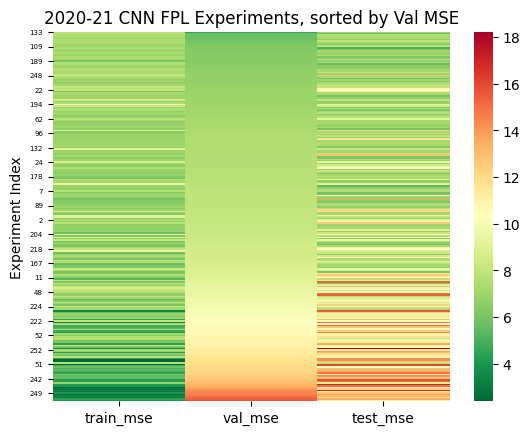


2020-21 Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,2020-21,GK,3,2,128,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
DEF,2020-21,DEF,3,2,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
MID,2020-21,MID,3,1,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
FWD,2020-21,FWD,9,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True



2020-21 Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,8.141123,6.824385,7.916274
DEF,7.361140,5.961607,7.985064
MID,7.806750,4.545766,7.036894
FWD,8.474202,6.671063,12.801478



Average Val Performance:
6.000705361366272

Average Test Performance:
8.934927344322205


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,2020-21,GK,3,2,128,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
DEF,2020-21,DEF,3,2,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
MID,2020-21,MID,3,1,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
FWD,2020-21,FWD,9,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True


In [148]:
gridsearch_analysis('gridsearch_v4_singleyear_drop', 
                    season='2020-21',
                    eval_top=1)

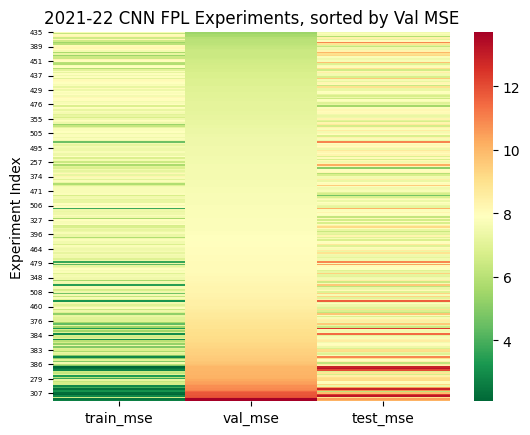


2021-22 Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,2021-22,GK,3,1,64,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
DEF,2021-22,DEF,3,1,64,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
MID,2021-22,MID,9,2,64,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
FWD,2021-22,FWD,3,2,128,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True



2021-22 Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,6.282449,5.409356,7.727600
DEF,8.258613,6.538323,7.482368
MID,7.688234,5.407370,7.526227
FWD,8.200192,6.277791,7.468069



Average Val Performance:
5.908209919929504

Average Test Performance:
7.551065683364868


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,2021-22,GK,3,1,64,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
DEF,2021-22,DEF,3,1,64,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
MID,2021-22,MID,9,2,64,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
FWD,2021-22,FWD,3,2,128,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True


In [149]:
gridsearch_analysis('gridsearch_v4_singleyear_drop', 
                    season='2021-22',
                    eval_top=1)

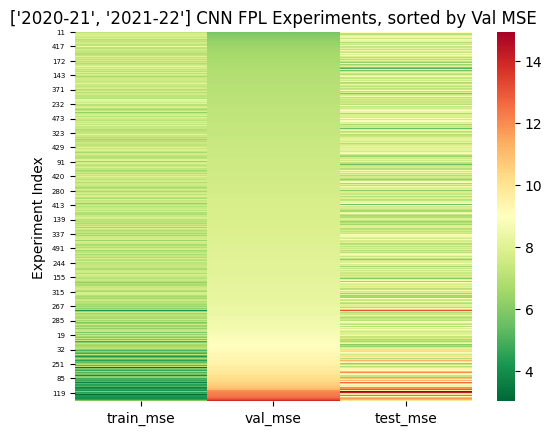


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 3 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,"['2020-21', '2021-22']",GK,3,1,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
DEF,"['2020-21', '2021-22']",DEF,6,2,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
MID,"['2020-21', '2021-22']",MID,3,2.0,64.0,128.0,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True



['2020-21', '2021-22'] Mean Performance of Top 3 Model by Position


,train_mse,val_mse,test_mse
GK,7.726385,5.961474,7.941252
DEF,7.698494,6.388040,7.966989
MID,7.488968,5.829319,8.056349
FWD,8.242097,6.646223,7.732026



Average Val Performance:
6.2062638600667315

Average Test Performance:
7.924153963724772


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,"['2020-21', '2021-22']",GK,3,1,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
DEF,"['2020-21', '2021-22']",DEF,6,2,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
MID,"['2020-21', '2021-22']",MID,3,2.0,64.0,128.0,relu,relu,True,15.0,adam,0.01,mse,['mae'],0.001,True,0.0001,20.0,True
FWD,"['2020-21', '2021-22']",FWD,6,3,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True


In [150]:
gridsearch_analysis('gridsearch_v5', eval_top=3)

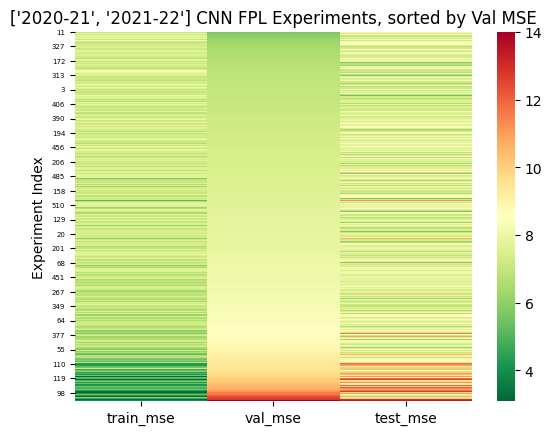


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


,season,position,window_size,kernel_size,num_filters,num_dense,conv_activation,dense_activation,drop_low_playtime,low_playtime_cutoff,optimizer,learning_rate,loss,metrics,regularization,early_stopping,tolerance,patience,standardize
GK,"['2020-21', '2021-22']",GK,3,1,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
DEF,"['2020-21', '2021-22']",DEF,3,1,128,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
MID,"['2020-21', '2021-22']",MID,6,2,64,128,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True
FWD,"['2020-21', '2021-22']",FWD,6,1,64,64,relu,relu,True,15,adam,0.01,mse,['mae'],0.001,True,0.0001,20,True



['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


,train_mse,val_mse,test_mse
GK,7.776814,5.582450,7.750151
DEF,7.976913,6.024108,8.130019
MID,7.096155,5.641898,8.965348
FWD,8.390717,6.224425,7.164237



Average Val Performance:
5.868220329284668

Average Test Performance:
8.00243878364563


In [151]:
best_hyperparams = gridsearch_analysis('gridsearch_v4_optimal_drop', 
                    eval_top=1)